In [13]:
## This script is to plot CLIMA mcape evolution in DA and NODA DETERMINISTIC
## for 18Z and 21Z
## created by C. Bayu Risanto, S.J. (3 October 2024)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import matlib
import pandas as pd
import xarray as xr
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mplotcolors
from matplotlib import cm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import date, datetime, timedelta
import glob
def read_nx(ncfile):
    dx = xr.open_dataset(ncfile)
    mcape = dx.mcape[:,:]
    return mcape
def read_latlon(ncfile):
    dx = xr.open_dataset(ncfile)
    lat = dx.XLAT[0,:,:]
    lon = dx.XLONG[0,:,:]
    return lat,lon

In [2]:
## days of rain
DR = ['2021-07-03','2021-07-09','2021-07-10','2021-07-12','2021-07-13','2021-07-14',
      '2021-07-15','2021-07-16','2021-07-18','2021-07-21','2021-07-22','2021-07-23',
      '2021-07-24','2021-07-25','2021-07-29','2021-07-30','2021-08-10','2021-08-11',
      '2021-08-13','2021-08-15','2021-08-16','2021-08-30','2021-08-31','2021-09-01']

In [3]:
## read data DETER both DA and NODA
path = '/home/bayu/DATA/ARIZONA_PRO/WRF_EXTR/WRF_OUT'
hor = [18,21]
aCY = [] ; aNY = []
for ih in hor:
    mcapCY = [] ; mcapNY = []
    for i in range(len(DR)):
        dir1 = DR[i][0:4]+DR[i][5:7]+DR[i][8:10]+'_06Z_mc08_40mem_0035_6cyc_assim'
        dir2 = DR[i][0:4]+DR[i][5:7]+DR[i][8:10]+'_06Z_mc08_40mem_0035_6cyc_noassim'
        fCY = 'ncl-2D_d02_*_'+str(ih).zfill(2)+':00:00.nc'
        fNY = 'ncl-2D_d02_*_'+str(ih).zfill(2)+':00:00.nc'
        Lcy = glob.glob(path+'/'+dir1+'/'+fCY); Lny = glob.glob(path+'/'+dir2+'/'+fNY)
        capCY = read_nx(Lcy[0])
        capNY = read_nx(Lny[0])
        mcapCY.append(capCY); mcapNY.append(capNY)
    mcapCY = np.asarray(mcapCY); mcapNY = np.asarray(mcapNY)
    aCY.append(mcapCY); aNY.append(mcapNY)
aCY = np.asarray(aCY); aNY = np.asarray(aNY)

In [4]:
print(aCY.shape)

(2, 24, 405, 684)


In [21]:
## Calculate the mean
mu_CY = np.nanmean(aCY,axis=1)
mu_NY = np.nanmean(aNY,axis=1)
diff = np.nanmean(aCY - aNY,axis=1)

## caculate mean domain
mc_CY = [np.round(np.nanmean(mu_CY[i,:,:].flatten()),2) for i in range(2)]
mc_CY = np.asarray(mc_CY)
mc_NY = [np.round(np.nanmean(mu_NY[i,:,:].flatten()),2) for i in range(2)]
mc_NY = np.asarray(mc_NY)
mc_dif = [np.round(np.nanmean(diff[i,:,:].flatten()),2) for i in range(2)]
mc_dif = np.asarray(mc_dif)
quant = np.stack((mc_CY,mc_NY,mc_dif)).flatten('F')

## Student's t-test
m_Y_da = np.nanmean(np.nanmean(aCY,axis=3),axis=2)
m_Y_no = np.nanmean(np.nanmean(aNY,axis=3),axis=2) 
sigf0 = stats.ttest_ind(m_Y_da[0,:],m_Y_no[0,:]) ; #print(sigf0)
sigf1 = stats.ttest_ind(m_Y_da[1,:],m_Y_no[1,:]) ; #print(sigf1)
ttest0 = str(np.round(sigf0[0],2)); pval0 = str(np.round(sigf0[1],3))
ttest1 = str(np.round(sigf1[0],2)); pval1 = str(np.round(sigf1[1],3))
print(ttest0, pval0)
print(ttest1, pval1)

3.9 0.0
6.45 0.0


In [22]:
print(quant)

[392.57 236.39 162.94 517.21 282.56 250.52]


In [23]:
## get latlon
pathlx = '/home/bayu/DATA/ARIZONA_PRO/metadata/'
xlat,xlon = read_latlon(pathlx+'lonlat.nc')
#xlat_c = xlat[0:max_lat,0:max_lon]; xlon_c = xlon[0:max_lat,0:max_lon]

## get contour hgt
ds = xr.open_dataset('/home/bayu/DATA/ARIZONA_PRO/metadata/HGT_d01.nc')
HGT = ds.HGT[0,:,:]
HXLAT = ds.XLAT[0,:,:]
HXLON = ds.XLONG[0,:,:]

## get rid of anything less than 0 m
HGT = HGT.where(HGT >= 1)

In [24]:
## get obs data 227 is AUG 15
obs_link = '/home/bayu/DATA/ARIZONA_PRO/OBS/GPS_2021/GPS_DAVID-SUOMI_hr-ORI/'
fobs = 'TransDS_hr_2021'+'08'+'15'+'18'+'.dat'
d_obs = pd.read_csv(obs_link+fobs,header=None,delimiter=r"\s+")
sta = d_obs.iloc[:,0].tolist()

## get the obs lat lon
obslatlon_link = '//home/bayu/DATA/ARIZONA_PRO/metadata/'
flatlon = 'GPS_DAVID-SUOMI_sites_2021.txt'
latlon = pd.read_csv(obslatlon_link+flatlon,header=None,delimiter=r"\s+")
n_latlon = latlon[latlon.iloc[:,3].isin(sta)]
Olon = n_latlon.iloc[:,0].tolist()
Olat = n_latlon.iloc[:,1].tolist()
Oname = n_latlon.iloc[:,3].tolist()

In [25]:
xticks = np.arange(-114.,-108,2)
yticks = np.arange(31.,38.,1)
## create background
crs = ccrs.PlateCarree()
def plot_background(ax):
    ax.set_extent([-115.,-109.,31.5,37.5], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=1.4,zorder=3)
    #ax.add_feature(cfeature.BORDERS,linestyle=':',linewidth=0.7,zorder=3)
    ax.add_feature(cfeature.STATES,linestyle=':',linewidth=0.7,zorder=3)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.set_xticklabels(xticks, rotation=0, fontsize=12)
    ax.set_yticklabels(yticks, rotation=0, fontsize=12)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.contour(HXLON,HXLAT,HGT,6,vmin=0,vmax=2500,colors='k',linewidths=0.6)
    
    gl = ax.gridlines(ccrs.PlateCarree(),draw_labels=False,linewidth=2,color='gray',
                     alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    gl.xlines = False; gl.ylines = False
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    
    return ax

In [26]:
## color cape
var_range = np.arange(0,3500,200)
var_range = np.arange(0,2200,200)
var_col = cm.get_cmap('Spectral',35)
varcol = var_col(np.linspace(0,1,35))
VARcol = mplotcolors.ListedColormap(varcol,'probability').reversed()
var_norm = mplotcolors.BoundaryNorm(var_range,VARcol.N)
var_diff = np.arange(-1000,1001,100)

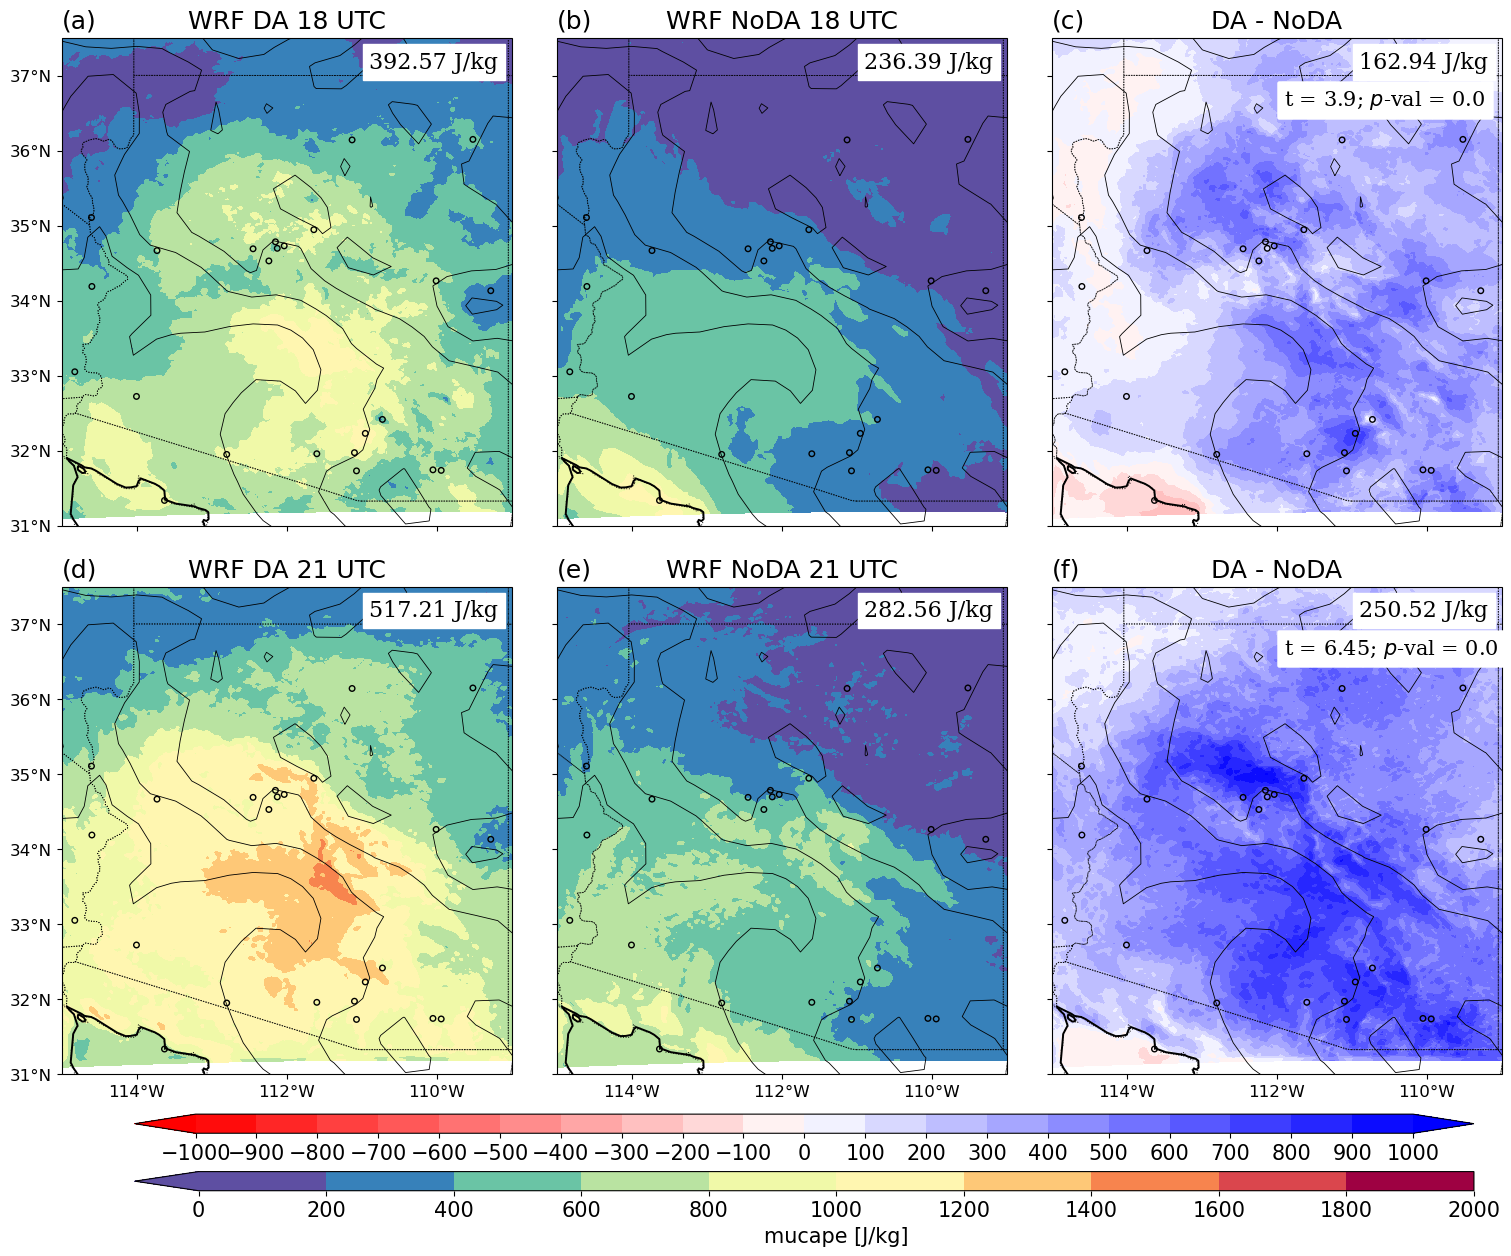

In [33]:
###########################################
# Plot #           
###########################################
projection = ccrs.PlateCarree()
fig, axe = plt.subplots(2, 3, figsize=(18, 16),
                                   subplot_kw={'projection': projection})
## AX1
axlist = axe.flatten()
c = 0
for ax1 in axlist:
    plot_background(ax1)
    p0 = axlist[0].contourf(xlon,xlat,mu_CY[0,:,:],
                           var_range,cmap=VARcol,norm=var_norm,extend='min',transform=projection,) 
    p1 = axlist[1].contourf(xlon,xlat,mu_NY[0,:,:],
                           var_range,cmap=VARcol,norm=var_norm,extend='min',transform=projection,)
    p2 = axlist[2].contourf(xlon,xlat,diff[0,:,:],
                           var_diff,cmap='bwr_r',extend='both',transform=projection,)
    p3 = axlist[3].contourf(xlon,xlat,mu_CY[1,:,:],
                           var_range,cmap=VARcol,norm=var_norm,extend='min',transform=projection,) 
    p4 = axlist[4].contourf(xlon,xlat,mu_NY[1,:,:],
                           var_range,cmap=VARcol,norm=var_norm,extend='min',transform=projection,)
    p5 = axlist[5].contourf(xlon,xlat,diff[1,:,:],
                           var_diff,cmap='bwr_r',extend='both',transform=projection,)
    
    axlist[1].set_yticklabels([]);axlist[2].set_yticklabels([])
    axlist[4].set_yticklabels([]);axlist[5].set_yticklabels([])
    axlist[0].set_xticklabels([]);axlist[1].set_xticklabels([]);axlist[2].set_xticklabels([])
    
    ## set title
    t0 = axlist[0].set_title('WRF DA '+ str(hor[0]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t0 = axlist[0].set_title('(a)',loc='left',pad=7,fontsize=18)
    t1 = axlist[1].set_title('WRF NoDA '+str(hor[0]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t1 = axlist[1].set_title('(b)',loc='left',pad=7,fontsize=18)
    t2 = axlist[2].set_title('DA - NoDA',
                            loc='center',pad=7,fontsize=18)
    t2 = axlist[2].set_title('(c)',loc='left',pad=7,fontsize=18)
    t3 = axlist[3].set_title('WRF DA '+ str(hor[1]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t3 = axlist[3].set_title('(d)',loc='left',pad=7,fontsize=18)
    t4 = axlist[4].set_title('WRF NoDA '+str(hor[1]).zfill(2)+' UTC',
                            loc='center',pad=7,fontsize=18)
    t4 = axlist[4].set_title('(e)',loc='left',pad=7,fontsize=18)
    t5 = axlist[5].set_title('DA - NoDA',
                            loc='center',pad=7,fontsize=18)
    t5 = axlist[5].set_title('(f)',loc='left',pad=7,fontsize=18)
    
    ## obs
    s0 = axlist[0].scatter(Olon,Olat,s=16,edgecolor='k')
    s0.set_facecolor('none')
    s1 = axlist[1].scatter(Olon,Olat,s=16,edgecolor='k')
    s1.set_facecolor('none')
    s2 = axlist[2].scatter(Olon,Olat,s=16,edgecolor='k')
    s2.set_facecolor('none')
    s3 = axlist[3].scatter(Olon,Olat,s=16,edgecolor='k')
    s3.set_facecolor('none')
    s4 = axlist[4].scatter(Olon,Olat,s=16,edgecolor='k')
    s4.set_facecolor('none')
    s5 = axlist[5].scatter(Olon,Olat,s=16,edgecolor='k')
    s5.set_facecolor('none')
    
    ## quantity
    axlist[c].annotate(str(quant[c])+' J/kg',(-110.9,37.1),fontsize=16, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
    c = c + 1
    axlist[2].annotate('t = '+ttest0+ '; $p$-val = '+pval0,(-111.9,36.6),fontsize=15, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
    axlist[5].annotate('t = '+ttest1+ '; $p$-val = '+pval1,(-111.9,36.6),fontsize=15, fontname='serif',
            bbox=dict(boxstyle='square',fc='w',ec='w'))
    
#Add precip colorbar
cbar0 = fig.colorbar(p0,ticks=var_range,ax=axe,orientation='horizontal',
                    shrink=0.96,aspect=70,pad=0.01,anchor=(0.5,-0.8))
cbar0.ax.tick_params(labelsize=15)
cbar0.set_label('mucape [J/kg]',fontsize=15)

cbar1 = fig.colorbar(p2,ticks=var_diff,ax=axe,orientation='horizontal',
                    shrink=0.96,aspect=70,pad=0.01,anchor=(0.5,-2.0))
cbar1.ax.tick_params(labelsize=15)

#fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace= -0.25)

## SAVE
dir_out = '/home/bayu/PLOTS/ARIZONA_PRO/MUCAPE/'
plotfile  = 'MEAN_MUCAPE-18-21_DA-NODA-diff_UTC.png'
sf = fig.savefig(dir_out+plotfile, dpi=300, bbox_inches='tight')

## CLOSE
plt.show()
plt.close()